# Set-up

In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats
sc.settings.verbosity = 0

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [27]:
# File paths
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/snapatac2/merged.h5ads"
cell_annotations_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/2024_04_01/rna/regress_out/RNA_celltype.txt"

# Color paths
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/2023_11_26/cellid_colors.tsv"

# Figure directory
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_control/2024_04_01/atac/analysis"

# Confirm they exist
assert os.path.exists(sample_metadata_path)
assert os.path.exists(h5ad_path)

# Make figure directory
os.makedirs(os.path.join(outdir_path, "embeddings"), exist_ok=True)
os.makedirs(os.path.join(outdir_path, "cluster_proportions"), exist_ok=True)

# Params
umap_key = "X_umap"
embedding_key = "X_spectral"
num_pcs = 10

# Load and format data

In [18]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
0,dm0b,0hr_control,WB_73,WB_74,A2,0,control
1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
2,dm12b,6hr_IFNg,WB_75,WB_76,A2,6,IFNg
3,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
4,dm21a,24hr_3-cyt,WB_11,WB_12,A2,24,3-cyt


In [19]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors["SC.EC.1"] = cellid_colors["SC.EC"]
cellid_colors["SC.EC.2"] = "#FFA07A"
cellid_colors

{'SC.beta': '#2a9df4',
 'SC.alpha': '#967bb6',
 'SC.EC': '#ff7f50',
 'SC.delta': '#dc143c',
 'proliferating_alpha': '#90ee90',
 'other': '#708090',
 'endocrine_progenitor': '#ff69b4',
 'SC.EC.1': '#ff7f50',
 'SC.EC.2': '#FFA07A'}

In [20]:
# Read in h5ad file
adataset = snap.read_dataset(h5ad_path)
adata = adataset.to_adata()
adataset.close()
adata

AnnData object with n_obs × n_vars = 37603 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'spectral_eigenvalue', 'AnnDataSet'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

In [21]:
# Merge metadata
bcs = adata.obs.index.tolist()
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

,sample,log_n_fragment,tsse,leiden_1,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm25a#AAACAGCCAAATGCCC-1,dm25a,4.328787,16.930776,6,dm25a,24hr_control,WB_19,WB_20,A2,24,control
dm25a#AAACAGCCAGGAACCA-1,dm25a,4.479777,17.811105,8,dm25a,24hr_control,WB_19,WB_20,A2,24,control
dm25a#AAACAGCCATTGTGCA-1,dm25a,3.991758,18.440083,2,dm25a,24hr_control,WB_19,WB_20,A2,24,control
dm25a#AAACATGCAATTGAGA-1,dm25a,4.302396,20.293587,2,dm25a,24hr_control,WB_19,WB_20,A2,24,control
dm25a#AAACCAACACTTAGGC-1,dm25a,4.089517,21.139626,6,dm25a,24hr_control,WB_19,WB_20,A2,24,control


In [22]:
# Add in cell annotation
cell_annotations = pd.read_csv(cell_annotations_path, sep="\t", index_col=0, header=None)
cell_annotations = cell_annotations.to_dict()[1]
adata.obs['annotation'] = adata.obs.index.map(cell_annotations)
adata.obs["annotation"].value_counts(dropna=False)

NaN         23513
SC.beta      4721
SC.alpha     4140
SC.EC.2      2642
SC.EC.1      2475
SC.delta      112
Name: annotation, dtype: int64

In [23]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_spectral"] = adata.obsm[embedding_key]
adata

AnnData object with n_obs × n_vars = 37603 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'spectral_eigenvalue', 'AnnDataSet'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

In [24]:
# Merge embedding values
embeddings = pd.DataFrame(adata.obsm["X_spectral"][:, :10], columns=[f"spectral{i}" for i in range(1, 11)], index=adata.obs.index)
adata.obs = pd.concat([adata.obs, embeddings], axis=1)
adata.obs.head()

,sample,log_n_fragment,tsse,leiden_1,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,...,spectral1,spectral2,spectral3,spectral4,spectral5,spectral6,spectral7,spectral8,spectral9,spectral10
dm25a#AAACAGCCAAATGCCC-1,dm25a,4.328787,16.930776,6,dm25a,24hr_control,WB_19,WB_20,A2,24,...,0.005859,-0.000418,0.000506,-0.000501,-0.000244,-0.000670,-0.000113,0.000083,0.000264,0.000084
dm25a#AAACAGCCAGGAACCA-1,dm25a,4.479777,17.811105,8,dm25a,24hr_control,WB_19,WB_20,A2,24,...,0.006391,-0.000204,0.000320,-0.000139,0.000171,0.000343,-0.000319,0.000333,0.000124,0.000083
dm25a#AAACAGCCATTGTGCA-1,dm25a,3.991758,18.440083,2,dm25a,24hr_control,WB_19,WB_20,A2,24,...,0.004950,-0.000081,-0.000089,-0.000140,0.000028,0.000275,-0.000286,-0.000143,0.000046,-0.000158
dm25a#AAACATGCAATTGAGA-1,dm25a,4.302396,20.293587,2,dm25a,24hr_control,WB_19,WB_20,A2,24,...,0.005932,-0.000441,-0.000005,-0.000205,0.000500,0.000159,-0.000530,0.000022,0.000011,0.000026
dm25a#AAACCAACACTTAGGC-1,dm25a,4.089517,21.139626,6,dm25a,24hr_control,WB_19,WB_20,A2,24,...,0.005205,0.000052,0.000081,0.000115,0.000044,-0.000202,-0.000189,0.000139,-0.000044,0.000060


In [25]:
# Remove any colors that are not in the data
timepoint_categories = adata.obs["timepoint"].unique()
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata.obs["annotation"].unique()}

In [26]:
# Timepoint should be a categorical variable with a gradient of colors that increases from 0, 6, 24, 48, 72
adata.obs["timepoint"] = adata.obs["timepoint"].astype("category")
adata.obs["timepoint"] = adata.obs["timepoint"].cat.reorder_categories(timepoint_categories)
adata.uns["timepoint_colors"] = list(plt.get_cmap("Reds")(np.linspace(0, 1, len(timepoint_categories))))

# Cell id should be a categorical variable 
adata.obs["annotation"] = adata.obs["annotation"].astype("category")
adata.obs["annotation"] = adata.obs["annotation"].cat.reorder_categories(cellid_colors.keys())
adata.uns["annotation_colors"] = list(cellid_colors.values())

# Calcluate correlations with embeddings

In [77]:
# Get ANOVA results for categorical variables
categorical_covariates = ["annotation", "batch", "condition", "timepoint"]
embeddings_anova_df = dc.get_metadata_associations(
    data=[embeddings, adata.obs],
    obs_keys=categorical_covariates,
)
embeddings_anova_df["-log10(p_adj)"] = -np.log10(embeddings_anova_df["p_adj"])
embeddings_anova_df.to_csv(os.path.join(outdir_path, "embeddings", "embeddings_anova.csv"))
embeddings_anova_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:01,  6.83it/s]

 30%|███       | 3/10 [00:00<00:01,  6.88it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.75it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.81it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.84it/s]

100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


,variable,pval,eta_sq,factor,p_adj,-log10(p_adj)
0,annotation,6.292695e-03,0.001173,spectral1,NaN,NaN
1,batch,NaN,NaN,spectral1,NaN,NaN
2,condition,NaN,NaN,spectral1,NaN,NaN
3,timepoint,1.098253e-39,0.011647,spectral1,NaN,NaN
4,annotation,0.000000e+00,0.338011,spectral2,NaN,NaN


In [13]:
# Get log counts
adata.obs["log1p_total_counts"] = np.log1p(adata.X.sum(axis=1)+1)

In [80]:
# Spearman correlations between embeddings and continuous covariates
continuous_covariates = ["log1p_total_counts", "tsse"]
embeddings_spearman_list = []
for pc in embeddings.columns:
    for cov in continuous_covariates:
        rho, p = stats.spearmanr(embeddings[pc], adata.obs[cov])
        embeddings_spearman_list.append([pc, cov, rho, p])
embeddings_spearman_df = pd.DataFrame(embeddings_spearman_list, columns=["dim", "covariate", "rho", "p"])
embeddings_spearman_df["-log10(p)"] = -np.log10(embeddings_spearman_df["p"])
embeddings_spearman_df.to_csv(os.path.join(outdir_path, "embeddings", "embeddings_spearman.csv"))
embeddings_spearman_df.head()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dim,covariate,rho,p,-log10(p)
0,spectral1,log1p_total_counts,-0.984004,0.000000e+00,inf
1,spectral1,tsse,0.059797,1.295080e-13,12.887703
2,spectral2,log1p_total_counts,-0.056654,2.271765e-12,11.643637
3,spectral2,tsse,0.266823,5.841159e-248,247.233501
4,spectral3,log1p_total_counts,-0.053002,5.247539e-11,10.280044


In [81]:
# For the highest ANOVA eta_sq, plot a violinplot of the embeddings vs the categorical variable
eta_sq_cutoff = 0.05
eta_sq_df = embeddings_anova_df[embeddings_anova_df["eta_sq"] > eta_sq_cutoff]

# Plot
for i, row in eta_sq_df.iterrows():
        fig, ax = plt.subplots(figsize=(10, 5))
        embedding = row["factor"]
        cov = row["variable"]
        eta_sq = row["eta_sq"]
        sns.violinplot(
            x=cov,
            y=embedding,
            data=adata.obs,
            ax=ax,
        )
        plt.title(f"{embedding} vs {cov} (eta_sq={eta_sq:.2f})")
        plt.savefig(os.path.join(outdir_path, "embeddings", f"{embedding}_vs_{cov}.png"), bbox_inches="tight")    
        plt.close()

2024-03-01 13:49:18 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-01 13:49:18 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-01 13:49:18 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-01 13:49:20 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-01 13:49:20 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

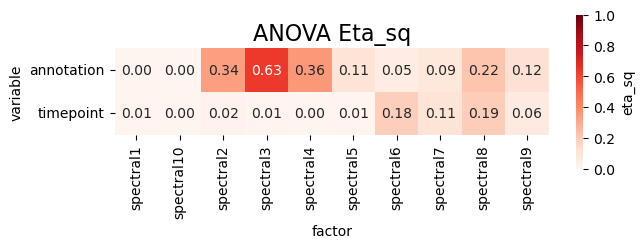

In [82]:
# Make a pretty heatmap of eta_sq for PC vs variable 
heatmap_df = embeddings_anova_df.pivot(index="variable", columns="factor", values="eta_sq")
heatmap_df = heatmap_df.dropna(axis=0, how="all")
fig, ax = plt.subplots(figsize=(7, 2))
sns.heatmap(heatmap_df, annot=True, cmap="Reds", ax=ax, cbar_kws={"label": "eta_sq"}, fmt=".2f", square=True, vmin=0, vmax=1)
plt.title("ANOVA Eta_sq", fontsize=16)
plt.savefig(os.path.join(outdir_path, "embeddings", "eta_sq_heatmap.png"), bbox_inches="tight")

In [85]:
# Pick two embedding_s and a covariate to plot nicely with large x and y labels and a legend title
embedding_1 = "2"
embedding_2 = "3"
covariate = "annotation"
with plt.rc_context({'axes.labelsize' : 'x-large'}):
    sc.pl.embedding(adata, basis="X_spectral", color=covariate, components=[embedding_1+","+embedding_2], legend_fontsize=12, show=False)
    plt.savefig(os.path.join(outdir_path, "embeddings", f"embedding_{embedding_1}_{embedding_2}_vs_{covariate}.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [86]:
# For the highest spearman rho, plot a scatterplot of the embeddings vs the continuous variable
rho_cutoff = 0.3
rho_df = embeddings_spearman_df[embeddings_spearman_df["rho"].abs() > rho_cutoff]

# Plot
for i, row in rho_df.iterrows():
        fig, ax = plt.subplots(figsize=(5, 5))
        embedding = row["dim"]
        cov = row["covariate"]
        rho = row["rho"]
        sns.scatterplot(
            x=cov,
            y=embedding,
            data=adata.obs,
            ax=ax,
        )
        plt.title(f"{embedding} vs {cov} (rho={rho:.2f})")
        plt.savefig(os.path.join(outdir_path, "embeddings", f"{embedding}_vs_{cov}.png"), bbox_inches="tight") 
        plt.close()

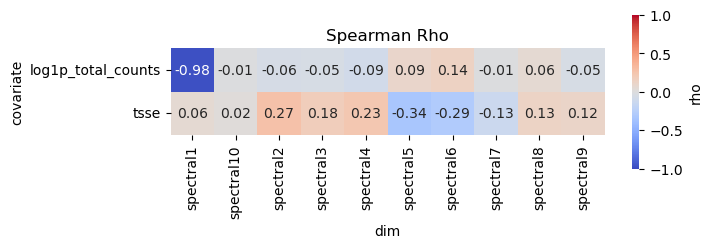

In [87]:
# Make a pretty heatmap of rho for PC vs variable
heatmap_df = embeddings_spearman_df.pivot(index="covariate", columns="dim", values="rho")
heatmap_df = heatmap_df.dropna(axis=1, how="all")
fig, ax = plt.subplots(figsize=(7, 2))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", ax=ax, vmin=-1, vmax=1, cbar_kws={"label": "rho"}, fmt=".2f", square=True)
plt.title("Spearman Rho")
plt.savefig(os.path.join(outdir_path, "embeddings", "rho_heatmap.png"), bbox_inches="tight")

In [88]:
# Pick a PC and a covariate to plot nice scatterplot with large x and y labels
pc = "spectral1"
covariate = "log1p_total_counts"
with plt.rc_context({'axes.labelsize' : 'x-large'}):
    ax = sc.pl.scatter(adata, x=covariate, y=pc, show=False, palette="viridis")
    plt.savefig(os.path.join(outdir_path, "embeddings", f"{pc}_vs_{covariate}.png"), bbox_inches="tight")
    plt.close()

# Plot dimensionality reductions

In [89]:
# embeddings plots
for cov in categorical_covariates + continuous_covariates:
    with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
        sc.pl.embedding(basis="X_spectral", adata=adata, color=[cov], show=False, components=["1,2", "3,4", "5,6", "7,8", "9,10", "11,12"], ncols=3)
        plt.savefig(os.path.join(outdir_path, "embeddings", f"embeddings_{cov}.png"), bbox_inches="tight")
        plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite

In [90]:
# Unsupervised clustering
with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
    sc.pl.umap(adata, color=["leiden_1", "annotation", "condition", "timepoint"], ncols=2, wspace=0.25, show=False)
    plt.savefig(os.path.join(outdir_path, "embeddings", "umap_all.png"), bbox_inches="tight")
    plt.close()
with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
    sc.pl.umap(adata, color=["sample"], wspace=0.2, show=False)
    plt.savefig(os.path.join(outdir_path, "embeddings", "umap_sample.png"), bbox_inches="tight")
    plt.close()
with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
    sc.pl.umap(adata, color=continuous_covariates, ncols=3, wspace=0.2, show=False)
    plt.savefig(os.path.join(outdir_path, "embeddings", "umap_continuous.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite

In [19]:
adata

AnnData object with n_obs × n_vars = 37603 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'spectral1', 'spectral2', 'spectral3', 'spectral4', 'spectral5', 'spectral6', 'spectral7', 'spectral8', 'spectral9', 'spectral10'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet', 'timepoint_colors', 'annotation_colors', 'condition_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


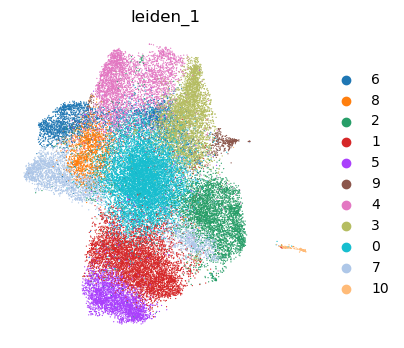

In [20]:
# Pick a continuous covariate to plot nice scatterplot with large x and y labels and title
covariate = "leiden_1"
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata, color=covariate, show=False, frameon=False, ax=ax)
plt.savefig(os.path.join(outdir_path, "embeddings", f"umap_{covariate}.png"), bbox_inches="tight")

In [21]:
adata.obs["sample"].value_counts()

dm35a    14890
dm45a    13093
dm25a     9620
Name: sample, dtype: int64

# Cluster proportions with metadata

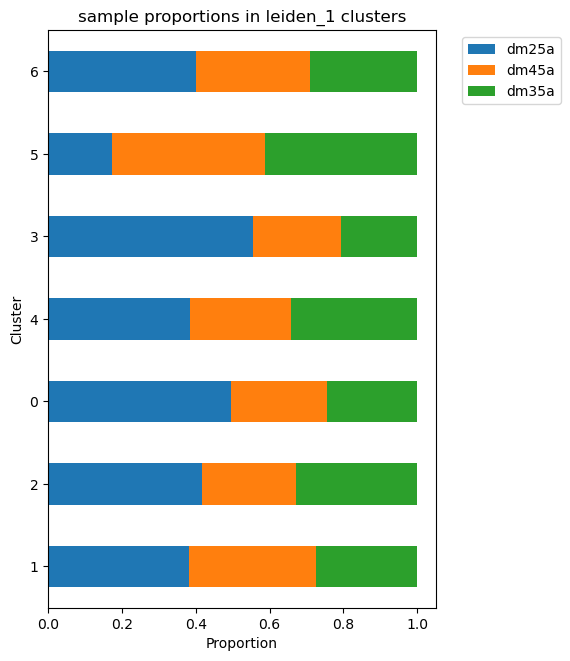

In [96]:
# Stacked barplot of sample proportions in leiden_1 clusters
leiden_1 = adata.obs["leiden_1.0"].unique().tolist()
sample_proportions = []
for cluster in leiden_1:
    proportions = adata.obs[adata.obs["leiden_1.0"] == cluster]["sample"].value_counts(normalize=True, dropna=False)
    proportions.name = cluster
    sample_proportions.append(proportions)
sample_proportions = pd.concat(sample_proportions, axis=1).T
#sample_proportions = sample_proportions[sample_categories]

# Plot horizontal barplot, legend outside to right
fig, ax = plt.subplots(figsize=(5, 7.5))
sample_proportions.plot.barh(stacked=True, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Proportion")
plt.ylabel("Cluster")
plt.title("sample proportions in leiden_1 clusters")
plt.savefig(os.path.join(outdir_path, "cluster_proportions", "sample_proportions.png"), bbox_inches="tight")

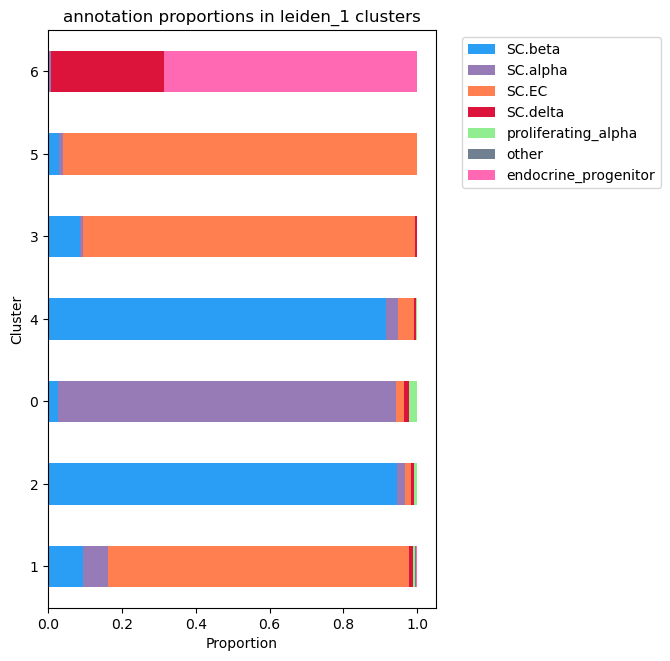

In [97]:
# Stacked barplot of annotation proportions in leiden_1 clusters
leiden_1 = adata.obs["leiden_1.0"].unique().tolist()
annotation_proportions = []
for cluster in leiden_1:
    proportions = adata.obs[adata.obs["leiden_1.0"] == cluster]["annotation"].value_counts(normalize=True, dropna=False)
    proportions.name = cluster
    annotation_proportions.append(proportions)
annotation_proportions = pd.concat(annotation_proportions, axis=1).T
annotation_proportions = annotation_proportions[cellid_colors.keys()]

# Plot horizontal barplot, legend outside to right
fig, ax = plt.subplots(figsize=(5, 7.5))
annotation_proportions.plot.barh(stacked=True, ax=ax, color=cellid_colors.values())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Proportion")
plt.ylabel("Cluster")
plt.title("annotation proportions in leiden_1 clusters")
plt.savefig(os.path.join(outdir_path, "cluster_proportions", "annotation_proportions.png"), bbox_inches="tight")

# DONE!

---

# Scratch